In [1]:
import numpy as np
from skyfield.api import load, Topos
import matplotlib.pyplot as plt

In [2]:
# Load ephemeris data
eph = load('de421.bsp')
earth, moon, sun = eph['earth'], eph['moon'], eph['sun']

ts = load.timescale()

#Calculation of the angular distance in equatorial coordinates
def angular_distance(ra1, dec1, ra2, dec2):
    ra1 = np.deg2rad(ra1 * 15)  # Convert hours to degrees
    ra2 = np.deg2rad(ra2 * 15)  # Convert hours to degrees
    dec1 = np.deg2rad(dec1)
    dec2 = np.deg2rad(dec2)
    cos_distance = np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
    distance = np.arccos(cos_distance)
    return np.rad2deg(distance)

#6 months starting March 21st and ending September 20th (46 days in total)
d_3 = np.arange(21,32,4)
d_4 = np.arange(2,31,4)
d_5 = np.arange(4,32,4)
d_6 = np.arange(1,31,4)
d_7 = np.arange(3,32,4)
d_8 = np.arange(4,32,4)
d_9 = np.arange(1,21,4)

In [3]:
from skyfield.api import EarthSatellite

#Ideal Satellite
line1_ideal = '1 00001U 20001A   24094.87500000  .00000000  00000-0  00000-0 0  0000'
line2_ideal = '2 00001   0.0000  0.0000 0000000  0.0000  0.0000  1.00000000  00000' # exactly 1 rev. per day
satellite_ideal = EarthSatellite(line1_ideal, line2_ideal, 'Ideal Satellite', ts)

This version is the current one, meaning that we calculate every 4th day and for every day every 30min. Also the safe position tests includes the points that are observable for 2 consecutive times. And the fields in the end are with distortion:

In [4]:
# The "containers" for all the equatorial coord values for the moon, earth and sun (order: RA, Dec)
moon_eq_values_24 = []
sun_eq_values_24 = []
earth_eq_values_24 = []

# Generate a grid of RA and Dec values
ra_grid = np.linspace(0, 24, 360)  # RA from 0 to 24 hours
dec_grid = np.linspace(-90, 90, 180)  # Dec from -90 to 90 degrees

In [5]:
# Trajectory of the moon every 30 minutes for 6 months every 4th day starting March 21st
for i in np.arange(3,10): # from March til September
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(moon)
                ra, dec, distance = astrometric.radec()
                moon_eq_values_24.append((ra.hours, dec.degrees)) 
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = (earth + satellite_ideal).at(t).observe(moon)
        ra, dec, distance = astrometric.radec()
        moon_eq_values_24.append((ra.hours, dec.degrees))
            
#Trajectory calculation for the sun
for i in np.arange(3,10): # from March til September
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(sun)
                ra, dec, distance = astrometric.radec()
                sun_eq_values_24.append((ra.hours, dec.degrees))
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = (earth + satellite_ideal).at(t).observe(sun)
        ra, dec, distance = astrometric.radec()
        sun_eq_values_24.append((ra.hours, dec.degrees))

#Trajectory for the earth observed from the satellite
for i in np.arange(3,10): # from March til September
    var = f'd_{i}'
    var_2 = globals()[var]
    for d in var_2:
        for h in np.arange(0,24):
            for m in np.arange(0,60,30):
                t = ts.utc(2024, i, d, h, m)
                astrometric = (earth + satellite_ideal).at(t).observe(earth)
                ra, dec, distance = astrometric.radec()
                earth_eq_values_24.append((ra.hours, dec.degrees))
        t = ts.utc(2024, i, d, 23, 59)
        astrometric = (earth + satellite_ideal).at(t).observe(earth)
        ra, dec, distance = astrometric.radec()
        earth_eq_values_24.append((ra.hours, dec.degrees))

Now we get to the actual safe sky positions:

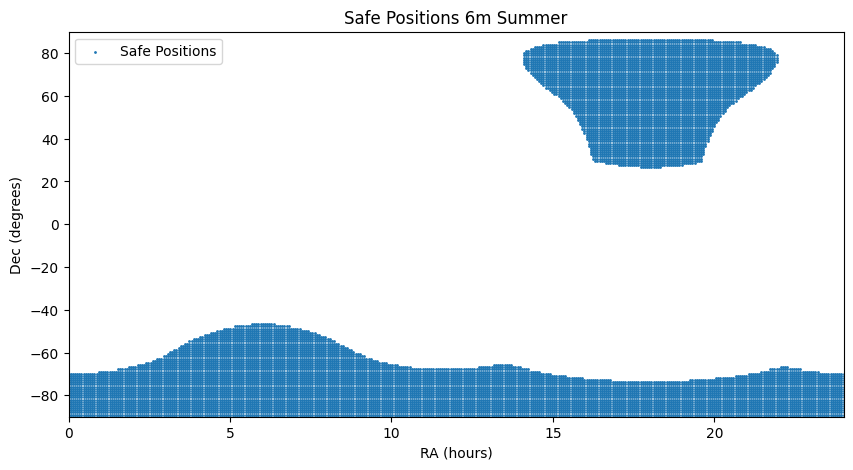

In [6]:
# Splitting the positions into lists of 49 bc for one day positions are calculated 49 times
day_size = 49
moon_daysplit = [moon_eq_values_24[i:i + day_size] for i in range(0, len(moon_eq_values_24), day_size)]
sun_daysplit = [sun_eq_values_24[i:i + day_size] for i in range(0, len(sun_eq_values_24), day_size)]
earth_daysplit = [earth_eq_values_24[i:i + day_size] for i in range(0, len(earth_eq_values_24), day_size)]

# Function to check if there are at least 2 consecutive valid time steps (equals 30min)
def has_consecutive_times(times, n=2):
    times = sorted(times)
    for i in range(len(times) - n + 1):
        if times[i + n - 1] - times[i] == n - 1:
            return True
    return False

# Main loop to check for safe RA-Dec combinations
safe_coord_24_new = []

for ra in ra_grid:
    for dec in dec_grid:
        is_safe = True
        
        for d in np.arange(0, 46):  # Loop over all the 46 days
            t = 0  # time step counter
            safe_t = []  # list for the safe time steps
            
            # Apply moon constraint
            for moon_ra, moon_dec in moon_daysplit[d]:
                if angular_distance(ra, dec, moon_ra, moon_dec) >= 35:
                    safe_t.append(t)
                t += 1
            
            # If there are fewer than 2 valid time steps, break early
            if len(safe_t) < 2:
                is_safe = False
                break
            
            # Apply sun constraint
            sun_day = sun_daysplit[d]
            safe_t_2 = []
            for x in safe_t:
                sun_day_step = sun_day[x]
                sun_distance = angular_distance(ra, dec, sun_day_step[0], sun_day_step[1])
                if 70 <= sun_distance <= 130:  # Sun constraint: between 70 and 130 degrees
                    safe_t_2.append(x)
            
            # If there are fewer than 2 valid time steps after the sun constraint, break early
            if len(safe_t_2) < 2:
                is_safe = False
                break
            
            # Apply earth constraint
            earth_day = earth_daysplit[d]
            safe_t_3 = []
            for y in safe_t_2:
                earth_day_step = earth_day[y]
                if angular_distance(ra, dec, earth_day_step[0], earth_day_step[1]) >= 48:
                    safe_t_3.append(y)
            
            # If there are fewer than 2 valid time steps after the earth constraint, break early, (kind of unnecessary since this is also tested by has_consecutive_times below)
            if len(safe_t_3) < 2:
                is_safe = False
                break
            
            # Check if there are at least 2 consecutive valid time steps
            if not has_consecutive_times(safe_t_3, n=2):
                is_safe = False
                break
        
        # If the ra-dec pair is safe for all days, add it to the list
        if is_safe:
            safe_coord_24_new.append((ra, dec))
            
safe_ra_24_new = [x[0] for x in safe_coord_24_new]
safe_dec_24_new = [y[1] for y in safe_coord_24_new]

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(safe_ra_24_new, safe_dec_24_new, s=1, label='Safe Positions')
plt.xlim(0, 24)
plt.ylim(-90, 90)
plt.xlabel('RA (hours)')
plt.ylabel('Dec (degrees)')
plt.title('Safe Positions 6m Summer')
plt.legend()
plt.show()

#plt.savefig('all_6m_summer', dpi=400)

For now I will skip the part where I try to squeeze fields inside the safe sky regions and directly include the SFD98 extinction map and map the safe sky regions over that and (hopefully) we'll see that it's not possible to fit nearly enough fields into the regions.

In [7]:
!pip install healpy

Defaulting to user installation because normal site-packages is not writeable


In [8]:
safe_ra_deg = [element * 15 for element in safe_ra_24_new]

safe_coord_deg = list(zip(safe_ra_deg, safe_dec_24_new)) # Creating a new list where both RA and Dec are in degrees

/tmp/ipykernel_74562/1478793888.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x500 with 0 Axes>

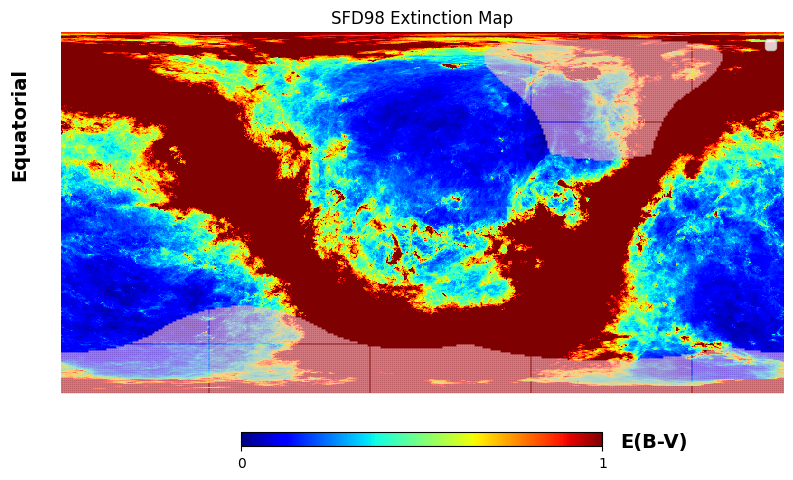

In [9]:
import healpy as hp
import matplotlib.pyplot as plt

# Replace this with the path to your lambda_sfd_ebv.fits file, source: https://lambda.gsfc.nasa.gov/product/foreground/fg_sfd_get.html
sfd_file = 'lambda_sfd_ebv.fits'

# Load the HEALPix data
ebv_map = hp.read_map(sfd_file, hdu=1)

# Convert RA/Dec (theta, phi) to Healpy pixel indices
safe_dec_nparray = np.array(safe_dec_24_new) # Converting the Dec points into np.array
safe_dec_nparray = -safe_dec_nparray # Inverting at the x axis, to match the new coordinate system
safe_ra_nparray = np.array(safe_ra_deg) # Converting the RA points into an np.array
ra_data_wrapped = safe_ra_nparray -180 # Switching to a system where RA ranges from -180° to 180°
ra_data_wrapped = -ra_data_wrapped # Inverting at the y axis because we also need to flip the other data later on

# Plot the overlapped map using `cartview` in Equatorial coordinates
fig = plt.figure(figsize=(10, 5))

# Plot the SFD98 extinction map
hp.cartview(6.7*ebv_map, coord=['G', 'C'], title="SFD98 Extinction Map", cmap='jet', unit='E(B-V)', min=0, max=1)

# Flip the plot upside down because for some reason the data is upside down
plt.gca().invert_yaxis()

# I think plot also needs to be flipped along the x-axis
plt.gca().invert_xaxis()

# Overlay your RA/Dec points directly on the map
plt.scatter(ra_data_wrapped, safe_dec_nparray, color='pink', alpha=0.4, s=1, marker='o')


# Add labels for RA/Dec if needed
plt.xlabel('Right Ascension [degrees]', fontsize=12)
plt.ylabel('Declination [degrees]', fontsize=12)

# Show the plot
plt.legend()
plt.show()